#  Load Dataset

In [1]:
import pandas as pd
image_path='/kaggle/input/flickr8k/Images'
data=pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Image Visualization


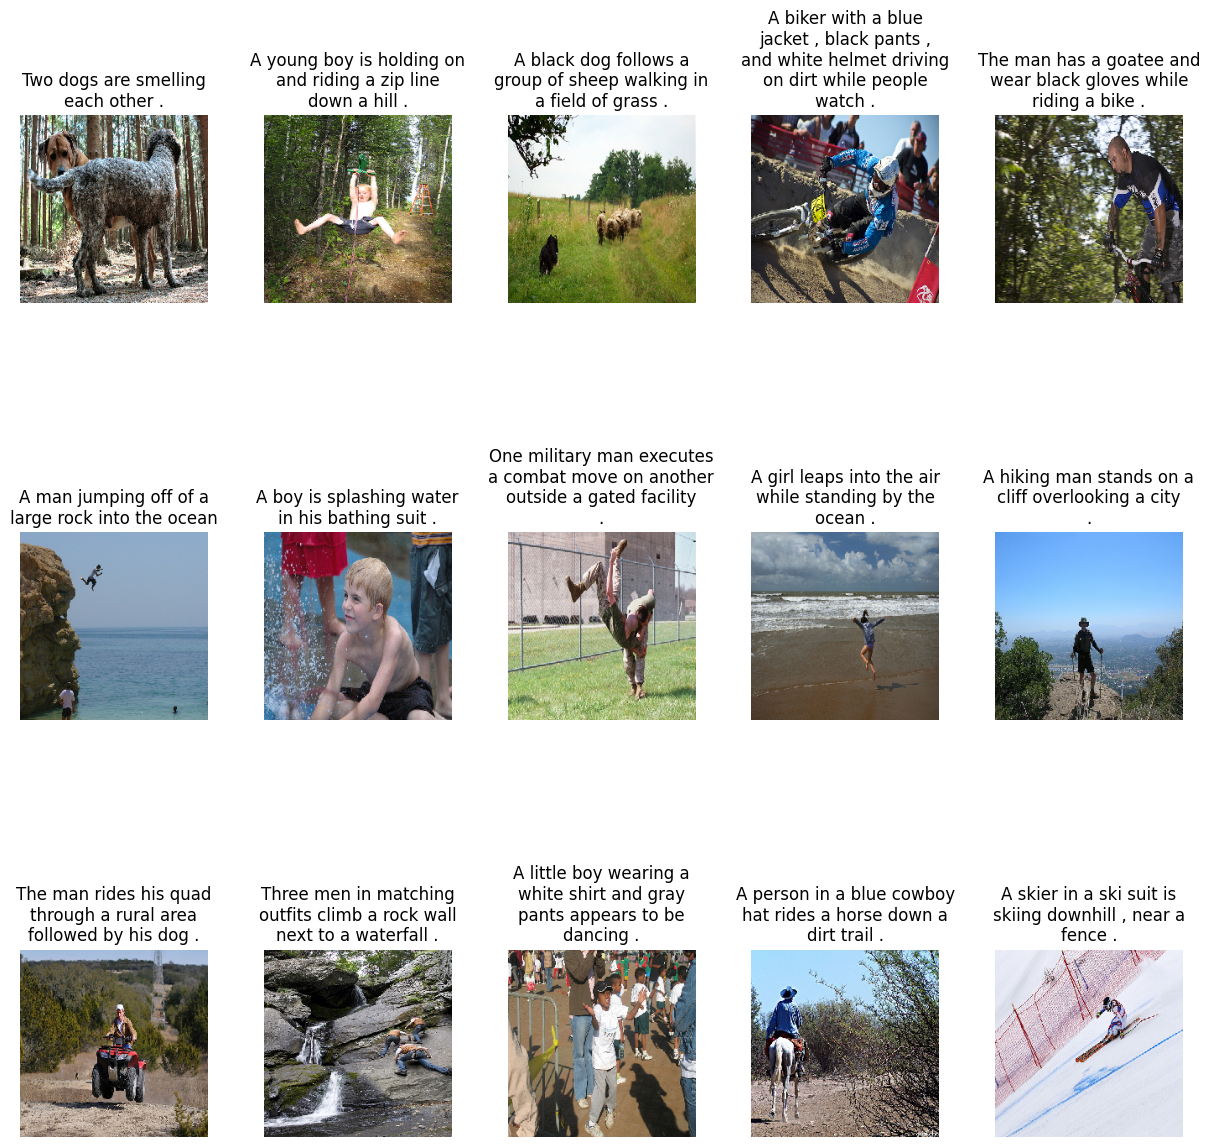

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from textwrap import wrap
import matplotlib.pyplot as plt
import os
def display_images(df):
    df = df.reset_index(drop=True)
    plt.figure(figsize = (15 , 15))
    image_folder = "/kaggle/input/flickr8k/Images"
    for idx,i in enumerate(range(15),1):
        plt.subplot(3 , 5, idx)
        image_name = df.image[i]
        image_path = os.path.join(image_folder, image_name)
        img = load_img(image_path,color_mode='rgb',target_size=(224,224))
        img = img_to_array(img)
        img = img/255.
        plt.imshow(img)
        plt.title("\n".join(wrap(df.caption[i], 25)))
        plt.axis("off")
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
display_images(data.sample(15))


# Text Preprocessing

In [5]:
import re #RegEx
def text_preprocessing(data):
    data['caption']=data['caption'].apply(lambda x:x.lower())
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^A-Za-z]', ' ', x))
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = data['caption'].apply(lambda x: "startseq " + x + " endseq")
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenization 

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(captions)

vocab_size=len(tokenizer.word_index)+1
max_length= max(len(caption.split()) for caption in captions)

images=data['image'].unique().tolist()
n_image=len(images)

split_index=round(n_image*0.85)
train_images=images[:split_index]
valid_images=images[split_index:]

train=data[data['image'].isin(train_images)]
valid=data[data['image'].isin(valid_images)]

train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

In [8]:
print(tokenizer.texts_to_sequences([captions[233]])[0])
print([captions[233]][0])

[1, 10, 76, 53, 27, 2256, 9, 28, 158, 36, 2]
startseq man stands by an elevator with his head down endseq


# Image Feature Extraction


In [12]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tqdm import tqdm
import numpy as np
model=DenseNet201()
fe=Model(inputs=model.input,outputs=model.layers[-2].output)
features={}
image_path='/kaggle/input/flickr8k/Images'
for image in tqdm(data['image'].unique().tolist()):
    img=load_img(os.path.join(image_path,image),target_size=(224,224))
    img=img_to_array(img)
    img=img/255.
    img=np.expand_dims(img,axis=0)
    feature=fe.predict(img,verbose=0)
    features[image]=feature
    

100%|██████████| 8091/8091 [14:36<00:00,  9.23it/s]


In [14]:
feature.shape 

(1, 1920)

In [15]:
feature[0].shape 

(1920,)

# Data Generation

In [17]:
from tensorflow.keras.utils import Sequence,to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=valid,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [18]:
train_generator[0]

((array([[7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523514e-01,
          2.2903769e-01, 6.9639754e-01],
         [7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523514e-01,
          2.2903769e-01, 6.9639754e-01],
         [7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523514e-01,
          2.2903769e-01, 6.9639754e-01],
         ...,
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

# Modelling


In [19]:
from tensorflow.keras.layers import Activation,Dropout,Dense,Input,Layer,Embedding,LSTM,add,Concatenate,Reshape,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
input1=Input(shape=(1920,))
input2=Input(shape=(max_length,))

img_features= Dense(256,activation='relu')(input1)
img_features_reshaped = Reshape((1, 256),input_shape=(256,))(img_features)

sentence_features=Embedding(vocab_size,256,mask_zero=False)(input2)
merged=concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features=LSTM(256)(merged)
sentence_features=Dropout(0.5)(sentence_features)

x = add([sentence_features, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output=Dense(vocab_size,activation='softmax')(x)
caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

model_name = "model.keras" 
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            save_weights_only=False,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0, 
                              patience = 5, 
                              verbose = 1, 
                              restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-8)

history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])



Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 5.6798
Epoch 1: val_loss improved from inf to 4.27406, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 137ms/step - loss: 5.6787 - val_loss: 4.2741 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 4.3274
Epoch 2: val_loss improved from 4.27406 to 3.95305, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 73s 136ms/step - loss: 4.3273 - val_loss: 3.9530 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 4.0137
Epoch 3: val_loss improved from 3.95305 to 3.80635, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 73s 136ms/step - loss: 4.0136 - val_loss: 3.8063 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 3.8191
Epoch 4: val_loss improved from 3.80635 to 3.72681, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 74s 138ms/step - loss: 3.8191 - val_loss: 3.7268 - learning_rate: 0.0010


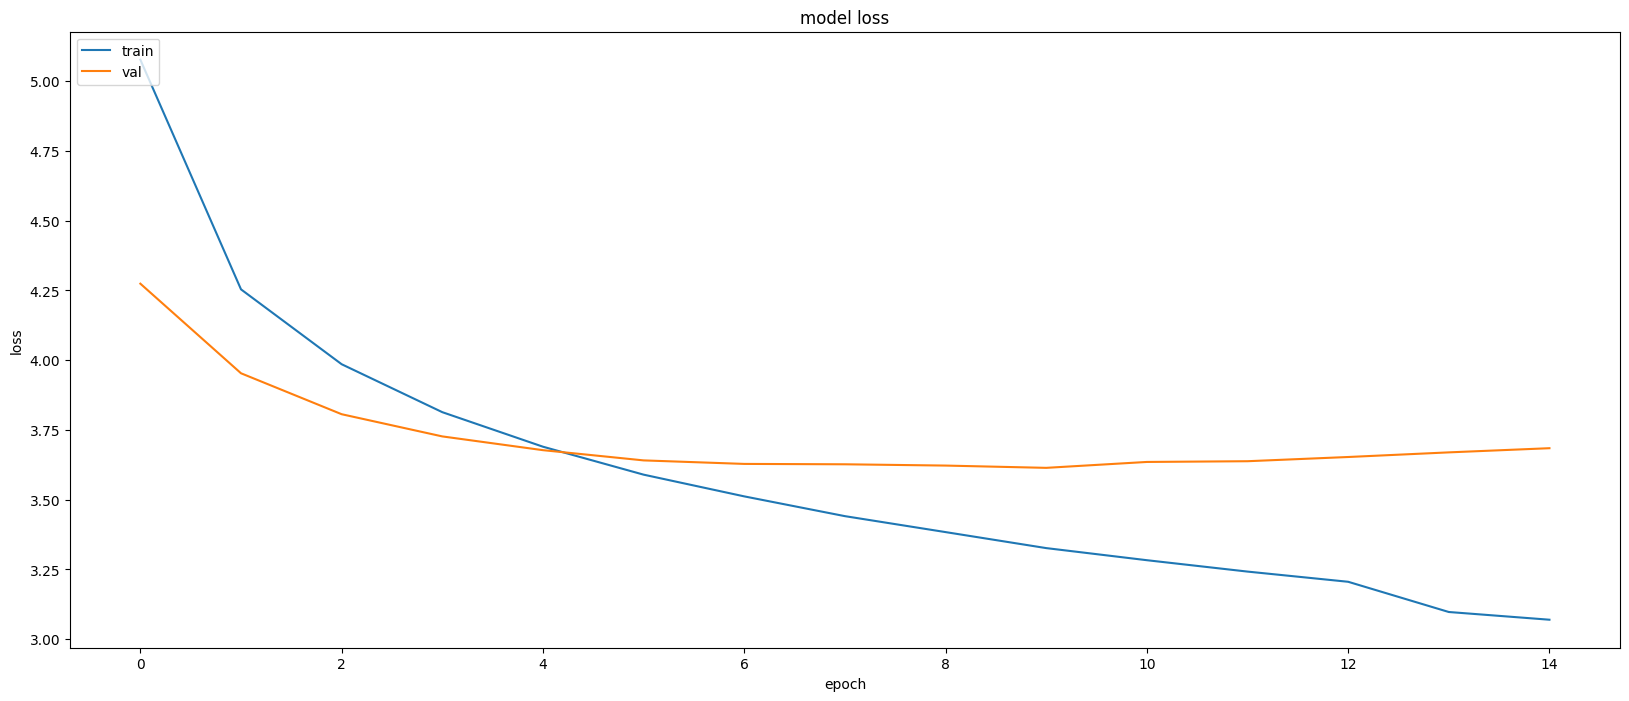

In [20]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
    
fe.save("feature_extractor.keras")

# Prediction

In [23]:
def predict_capt(image_path, true_caption=None, max_length=35, img_size=224):
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)
    image_features = fe.predict(img_array, verbose=0)

    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break

    predicted_caption = in_text.replace("startseq", "").replace("endseq", "").strip()
    
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')

    if true_caption:
        true_caption = true_caption.replace("startseq", "").replace("endseq", "").strip()
        plt.title(f"Prediction: {predicted_caption}\nTrue: {true_caption}", fontsize=12, color="green")
    else:
        plt.title(f"Prediction: {predicted_caption}", fontsize=14, color="green")

    plt.show()


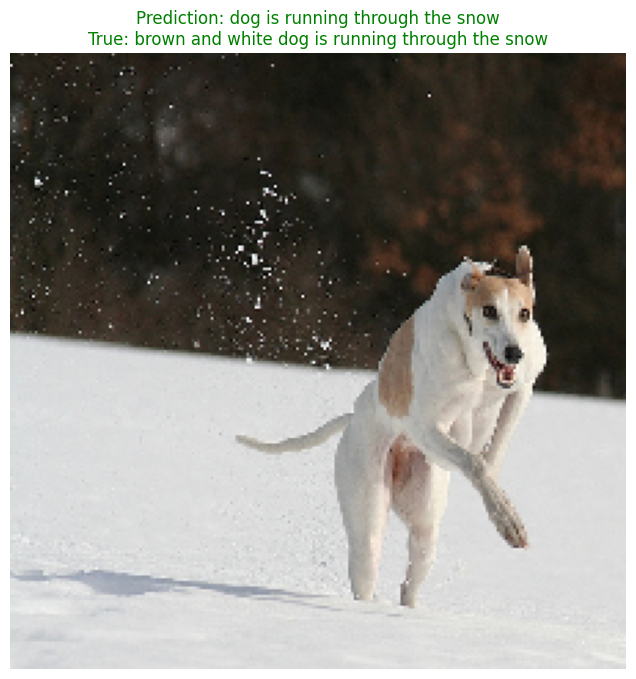

In [25]:
predict_capt("/kaggle/input/flickr8k/Images/101654506_8eb26cfb60.jpg",data[data['image'] == '101654506_8eb26cfb60.jpg']['caption'].values[0])